# Exploratory Data Analysis on Medical Records

In [5]:
from hydra import initialize, compose, utils
from omegaconf import OmegaConf
import pandas as pd
import os

current_directory = os.getcwd()

with initialize(version_base=None, config_path="../../config/"):
    cfg = compose(config_name='main.yaml')
    print(f"Process data using {cfg.data.raw.medical}")
    csv_file_path = os.path.join(current_directory, "../../", cfg.data.raw.medical)
    df = pd.read_csv(csv_file_path)
    print(df.head())

Process data using data/raw/02_medical_records.csv
   age gender chest_pain  resting_BP  cholesterol  fasting_BS resting_ECG  \
0   40      M        ATA         140          289           0      Normal   
1   49      F        NAP         160          180           0      Normal   
2   37      M        ATA         130          283           0          ST   
3   48      F        ASY         138          214           0      Normal   
4   54      M        NAP         150          195           0      Normal   

   max_HR exercise_angina  old_peak ST_slope  cv_issue  
0     172               N       0.0       Up         0  
1     156               N       1.0     Flat         1  
2      98               N       0.0       Up         0  
3     108               Y       1.5     Flat         1  
4     122               N       0.0       Up         0  


In [6]:
print("There are a toal of",df.shape[0],"records and",df.shape[1],"columns.")

There are a toal of 918 records and 12 columns.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   gender           918 non-null    object 
 2   chest_pain       918 non-null    object 
 3   resting_BP       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_BS       918 non-null    int64  
 6   resting_ECG      918 non-null    object 
 7   max_HR           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   old_peak         918 non-null    float64
 10  ST_slope         918 non-null    object 
 11  cv_issue         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<b>Dataframe Information</b>

- age: Age of a patient [years]
- gender: Gender of the patient [M: Male, F: Female]
- chest_pain: Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- resting_BP: Blood pressure in Hg (Normal blood pressure - 120/80 Hg)
- cholesterol: Serum cholestrol level in blood (Normal cholesterol level below for adults 200mg/dL)
- fasting_BS: Fasting Blood Sugar (Normal less than 100mg/dL for non diabetes for diabetes 100-125mg/dL)
- resting_ECG: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- max_HR: Maximum heart rate achieved [Numeric value between 60 and 202]
- exercise_angina: Exercise-induced angina [Y: Yes, N: No]
- old_peak oldpeak: ST [Numeric value measured in depression]
- ST_slope: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- cv_issue: output class [1: Has cardiovascular issue, 0: Normal]

# Duplicate and Null value

In [8]:
print("Number of duplicated records:",len(df[df.duplicated()]))

Number of duplicated records: 0


In [9]:
print("Number of null values in each column:\n",df.isna().sum())

Number of null values in each column:
 age                0
gender             0
chest_pain         0
resting_BP         0
cholesterol        0
fasting_BS         0
resting_ECG        0
max_HR             0
exercise_angina    0
old_peak           0
ST_slope           0
cv_issue           0
dtype: int64


No need to handle null values and duplicates.

# Categorical Columns

In [10]:
# explore categorical columns
object_columns = df.select_dtypes(include='object').columns.tolist()

In [11]:
object_columns

['gender', 'chest_pain', 'resting_ECG', 'exercise_angina', 'ST_slope']

In [12]:
for index in range(len(object_columns)):
    print(object_columns[index],"unique values:",df[object_columns[index]].unique())

gender unique values: ['M' 'F']
chest_pain unique values: ['ATA' 'NAP' 'ASY' 'TA']
resting_ECG unique values: ['Normal' 'ST' 'LVH']
exercise_angina unique values: ['N' 'Y']
ST_slope unique values: ['Up' 'Flat' 'Down']


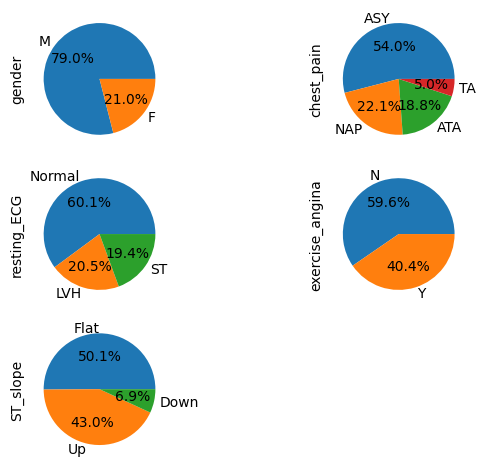

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3, 2)

(df['gender'].value_counts()/len(df)*100).plot(kind='pie', autopct = '%1.1f%%', ax=ax[0,0])
(df['chest_pain'].value_counts()/len(df)*100).plot(kind='pie', autopct = '%1.1f%%', ax=ax[0,1])
(df['resting_ECG'].value_counts()/len(df)*100).plot(kind='pie', autopct = '%1.1f%%', ax=ax[1,0])
(df['exercise_angina'].value_counts()/len(df)*100).plot(kind='pie', autopct = '%1.1f%%', ax=ax[1,1])
(df['ST_slope'].value_counts()/len(df)*100).plot(kind='pie', autopct = '%1.1f%%', ax=ax[2,0])
# rmv last subplot which is empty
fig.delaxes(ax[2,1])

plt.tight_layout()

<b>Categorical Variable Columns Information</b>

- gender: Gender of the patient [M: Male, F: Female]
- chest_pain: Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- resting_ECG: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- exercise_angina: Exercise-induced angina [Y: Yes, N: No]
- old_peak oldpeak: ST [Numeric value measured in depression]
- ST_slope: The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

None of the columns seem to be ordinal. Therefore, do one-hot encoding.

The exercise angina is a binary column, with value Y/N. Therefore, need to convert them to 0/1.

# Continuous Variable

<b>Continuous Variable Column Information</b>

- resting_BP: Blood pressure in Hg (Normal blood pressure - 120/80 Hg)
- cholesterol: Serum cholestrol level in blood (Normal cholesterol level below for adults 200mg/dL)
- fasting_BS: Fasting Blood Sugar (Normal less than 100mg/dL for non diabetes for diabetes 100-125mg/dL)
- max_HR: Maximum heart rate achieved [Numeric value between 60 and 202]
- oldpeak: ST [Numeric value measured in depression]

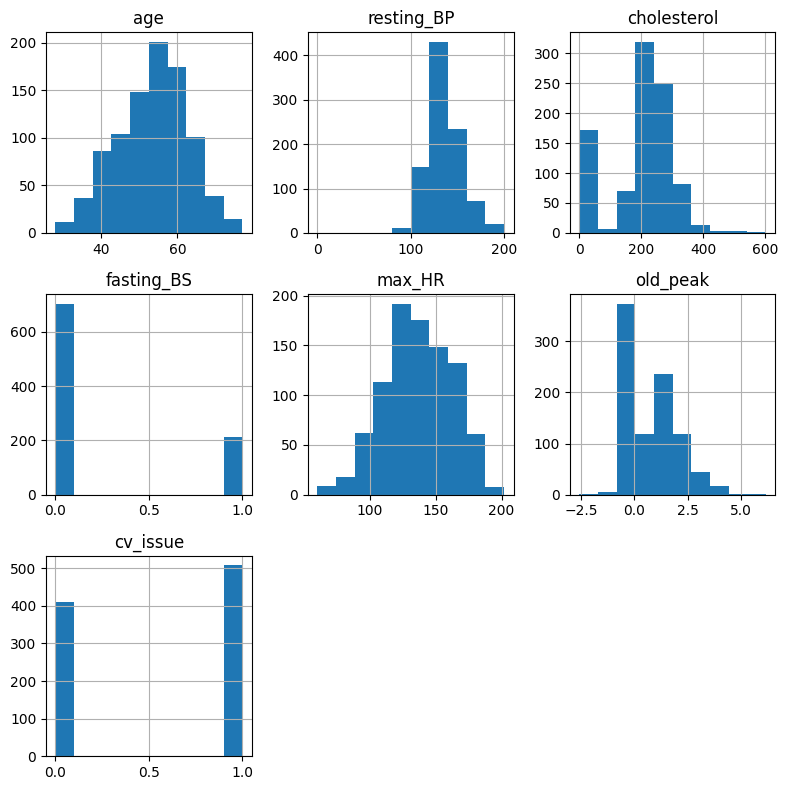

In [14]:
# explore continuous variables
df.hist(figsize=(8,8))
plt.tight_layout()

Some columns like cholesterol and old_peak looks skewed.

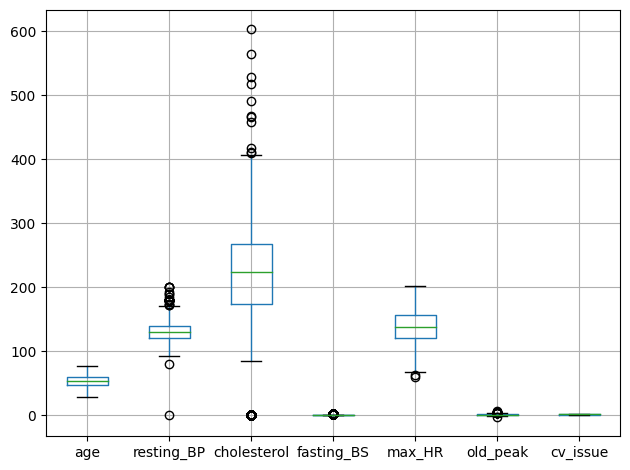

In [15]:
# check for outliers
df.boxplot()
plt.tight_layout()

Need to take a closer look at all columns except age, cv_issue, and fasting_BS.

age does not have any outliers (no circles on the boxplot) and cv_issue and fasting_BS is 0/1 value.

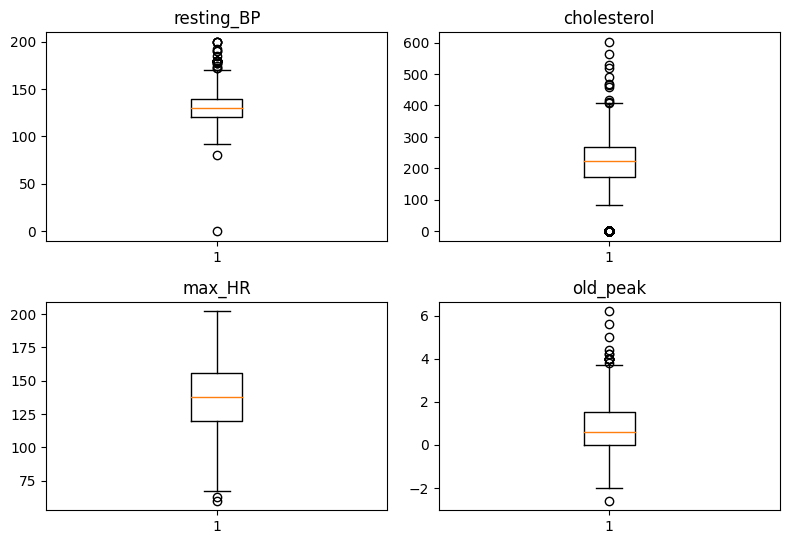

In [18]:
import matplotlib.pyplot as plt

columns_to_plot = ['resting_BP', 'cholesterol', 'max_HR', 'old_peak']

num_subplots = len(columns_to_plot)

# Create a grid of subplots with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

# Flatten the axes array to make it easier to iterate through the subplots
axes = axes.flatten()

# Plot each column as a separate boxplot in the corresponding subplot
for i, column in enumerate(columns_to_plot):
    axes[i].boxplot(x=df[column])
    axes[i].set_title(column)

# Remove any remaining empty subplots if the number of columns is less than 6
for j in range(num_subplots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # To improve the spacing between subplots
plt.show()

Need to remove outliers to reduce noise in the dataset. The values also have a wide range from 0 to 600 max. Therefore, standard scaling could be applied.

fasting_BS and cv_issue columns are binary as identified earlier. Let's look at the distribution ratio.

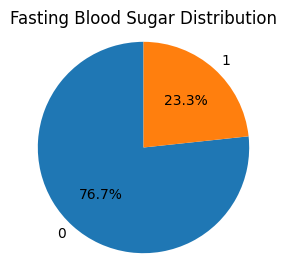

In [19]:
values = df['fasting_BS'].value_counts()  # Count occurrences of 0s and 1s
labels = values.index.tolist()  # Labels for the pie chart

plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Fasting Blood Sugar Distribution')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

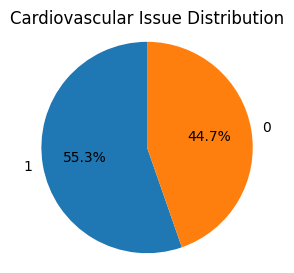

In [20]:
values = df['cv_issue'].value_counts()  # Count occurrences of 0s and 1s
labels = values.index.tolist()  # Labels for the pie chart

plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Cardiovascular Issue Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

No balancing of target column is required.

In [21]:
object_columns

['gender', 'chest_pain', 'resting_ECG', 'exercise_angina', 'ST_slope']

In [22]:
# label encode and see correlation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for columns in object_columns:
    df[columns] = label_encoder.fit_transform(df[columns])

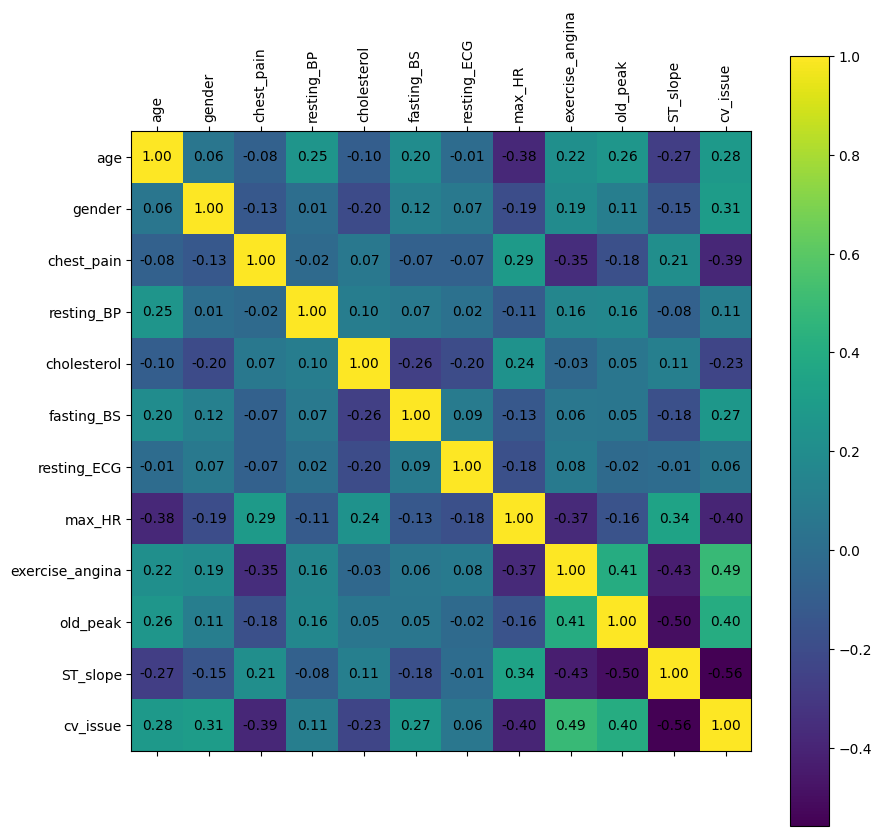

In [23]:
# checking correlation

def plot_corr(df, size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            text = "{:.2f}".format(corr.iloc[i, j])
            ax.text(i, j, text, ha='center', va='center', color='black')

    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

    plt.show()

plot_corr(df)

No highly/moderately correlated columns.

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        77
           1       0.90      0.90      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



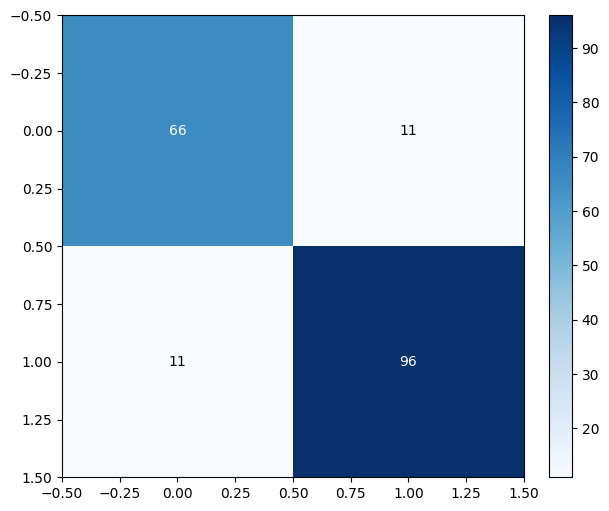

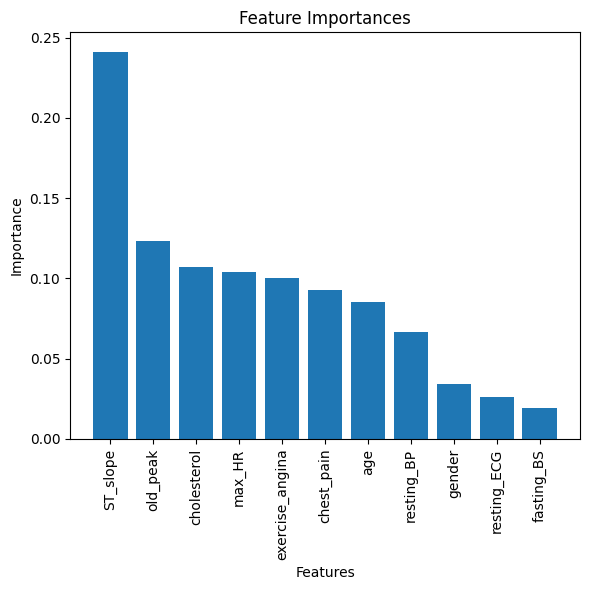

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=42)

x = df.drop(columns=['cv_issue'])
y = df['cv_issue']

# Let split the data into train and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

rf.fit(x_train, y_train)
y_predict = rf.predict(x_test)

#check model accuracy
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar(heatmap, fraction=0.046, pad=0.04)

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

feature_importance_df = pd.DataFrame({'Feature': df.columns.tolist()[:-1], 'Importance': rf.feature_importances_})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create the bar chart
plt.figure(figsize=(6, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Gender, Resting ECG, and Fasting_BS seems to have low feature importance.

Conclusion for Pycaret:
    
- Need one-hot encoding for the categorical columns: ['gender', 'chest_pain', 'resting_ECG', 'ST_slope']
- Convert categorical column 'exercise_angina' from 'No/Yes' to 0/1

- Binary variables are cv_issue (target column) and fasting_BS

- Remove outliers in the continuous variable columns ['resting_BP', 'cholesterol', 'max_HR', 'old_peak']

- Need to bin/normalize the numeric columns to reduce data complexity

- Need to set log experiment

- Set a session_id for repeatable results

- Multicollinearity to reduce dimension